In [1]:
# Bibliothèque nécessaires pour le projet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score, classification_report
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GroupKFold

# Analyse Préliminaire des datasets

In [2]:
others_features = pd.read_csv('data/training_others_features.csv')
pos_features = pd.read_csv('data/training_pos_features.csv')
pos_labels = pd.read_csv('data/training_pos_labels.csv')

Le nombre total de protéines 

In [3]:
# 1. Nombre total de protéines
# Supposons que chaque protéine a un identifiant unique dans 'Unnamed: 0'
all_proteins = pd.concat([pos_features[['Unnamed: 0']], others_features[['Unnamed: 0']]]).drop_duplicates()
num_proteins = all_proteins['Unnamed: 0'].nunique()
print(f"Nombre total de protéines : {num_proteins}")

Nombre total de protéines : 207747


Proportion de protéines positives : 0.10
Proportion de protéines négatives : 0.90


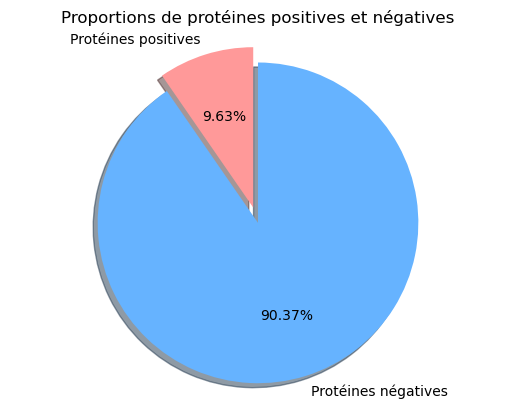

In [14]:
# 2. Proportions des labels positifs et négatifs
# Identifiants des protéines positives
positive_proteins = pos_labels['Unnamed: 0'].unique()  # Identifiants des protéines positives
num_positive = len(positive_proteins)
num_negative = num_proteins - num_positive
proportion_positive = num_positive / num_proteins
proportion_negative = num_negative / num_proteins

print(f"Proportion de protéines positives : {proportion_positive:.2f}")
print(f"Proportion de protéines négatives : {proportion_negative:.2f}")

# Représentation en diagramme circulaire
labels = ['Protéines positives', 'Protéines négatives']
sizes = [proportion_positive, proportion_negative]
colors = ['#ff9999','#66b3ff']
explode = (0.1, 0)  # Mettre en évidence la première tranche (protéines positives)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%.2f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Assurer que le cercle est dessiné comme un cercle.

plt.title('Proportions de protéines positives et négatives')
plt.show()

Avoir **90%** des éléments non labellisés et seulement **10%** labellisés présente plusieurs défis significatifs. 

* Tout d'abord, le déséquilibre des données peut rendre difficile la formation d'un modèle précis, car les données labellisées sont essentielles pour l'apprentissage supervisé.
* De plus, avec une si petite proportion de données labellisées, la qualité de l'apprentissage peut être compromise, ce qui risque de limiter la capacité du modèle à généraliser correctement.
* Il existe également un risque de biais si les données labellisées ne sont pas représentatives de l'ensemble des données. Enfin, le processus de labellisation manuelle des données peut être coûteux et chronophage.


Pour surmonter ce problème j'ai choisi de traiter le challenge de **PU-Learning** sous différentes approches que nous allons voir par la suite.

**Métriques appropriées pour valider le pipeline de Machine Learning**

**Métriques appropriées pour valider la pipeline de machine learning**

Dans un contexte où 90 % des données sont non labélisées et seulement 10 % des données sont positives (problème de PU learning), les métriques suivantes sont appropriées pour évaluer les performances du modèle :

* **AUC-ROC (Area Under the Receiver Operating Characteristic Curve)**

  L'AUC-ROC mesure la capacité du modèle à distinguer les classes positives des classes négatives sur toute la plage des seuils possibles. Cette métrique est particulièrement adaptée dans un problème déséquilibré, car elle évalue les performances globales du modèle indépendamment du seuil choisi.
  - Une courbe ROC bien équilibrée (proche de l'angle supérieur gauche) indique que le modèle est performant dans la séparation des classes.

* **Précision et Rappel (Precision et Recall)**

    Dans un problème déséquilibré, les métriques globales comme l'exactitude (accuracy) sont trompeuses, car un modèle qui prédit systématiquement la classe majoritaire (non labélisé) aurait une bonne performance apparente mais serait inutile.
    - Précision (Precision) : mesure la proportion de vrais positifs parmi les exemples prédits comme positifs. Cela permet de minimiser les faux positifs.
    - Rappel (Recall) : mesure la proportion de vrais positifs détectés parmi toutes les données positives réelles. Cela garantit que le modèle capture bien les exemples positifs, qui sont rares.

* **F1-Score**

  Le F1-Score est la moyenne harmonique de la précision et du rappel, et il est particulièrement utile lorsque les classes sont déséquilibrées. Cette métrique équilibre l'importance donnée aux faux positifs et aux faux négatifs, ce qui est crucial ici :

    - Si la précision est élevée mais que le rappel est faible (ou inversement), le F1-Score reflétera cet écart.

**Distribution des Labels et proportion des éléments multi-labels**

/tmp/ipykernel_21190/3621131742.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_distribution.index, y=label_distribution.values, palette="viridis")


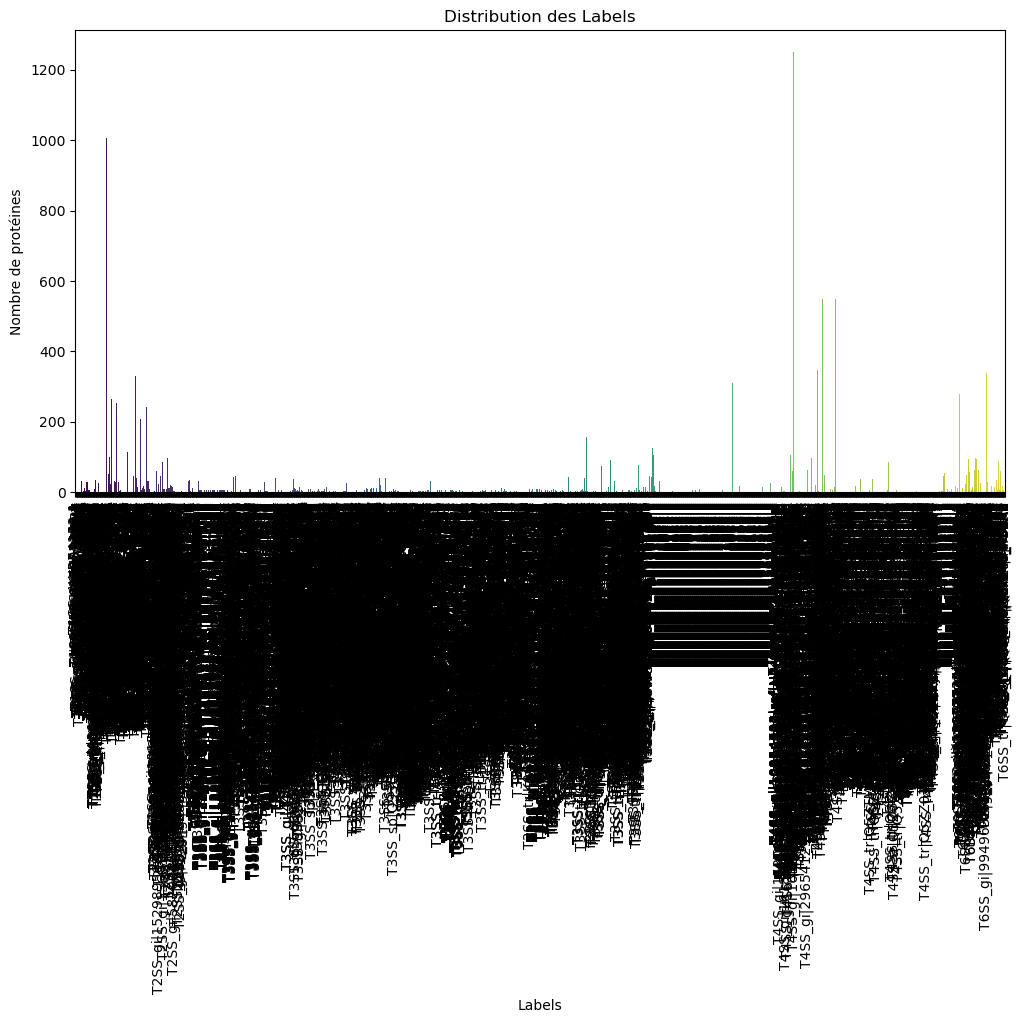

In [20]:
# Supposons que chaque colonne booléenne représente un label
label_distribution = pos_labels.iloc[:, 1:].sum()  # Exclure 'Unnamed: 0'

# Créer un graphique
plt.figure(figsize=(12, 6))
sns.barplot(x=label_distribution.index, y=label_distribution.values, palette="viridis")
plt.xticks(rotation=90)
plt.title("Distribution des Labels")
plt.xlabel("Labels")
plt.ylabel("Nombre de protéines")
plt.show()

Le graphe semble trop condensé, je vais représenter uniquement la distribution des **$100$** labels majoritaires en termes de protéines appartenant à leur classe.

/tmp/ipykernel_21190/1358016551.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_labels.index, y=top_labels.values, palette="viridis")


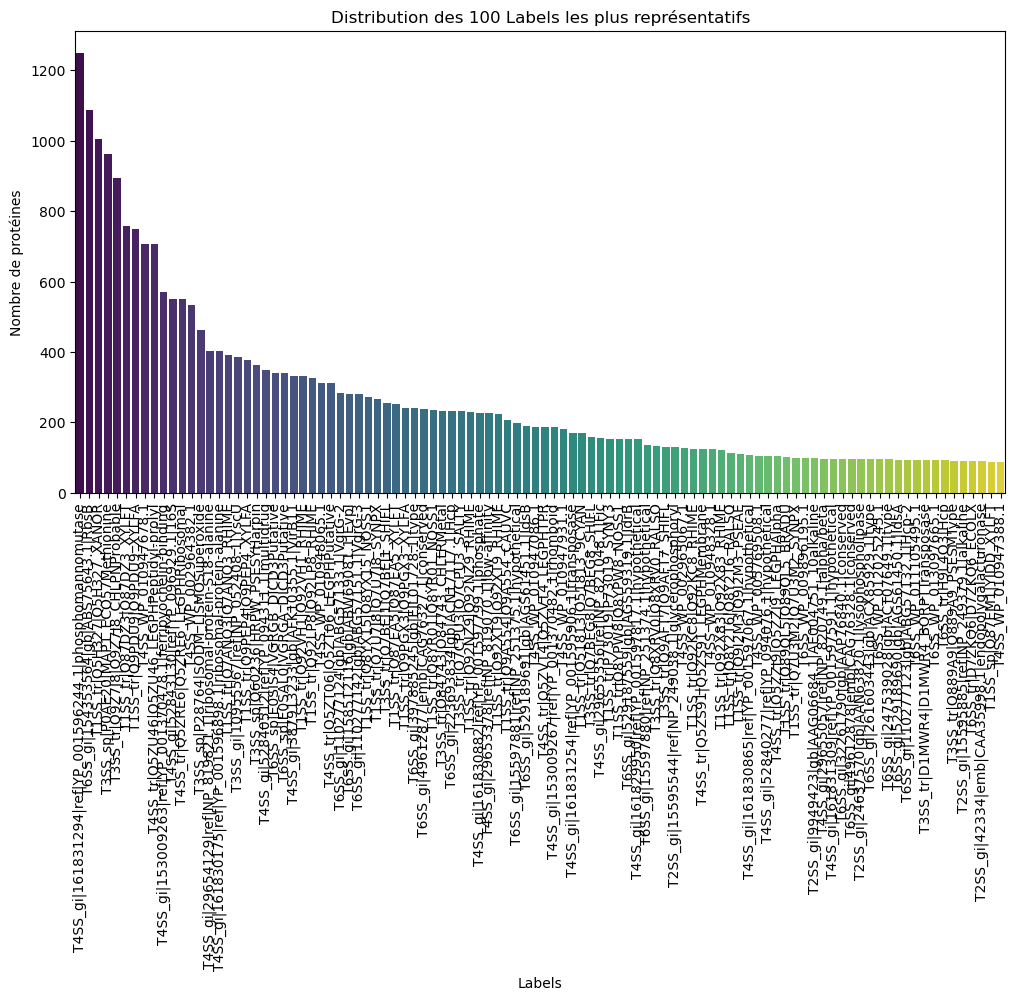

In [21]:
# Sélectionner les 100 premiers labels par ordre décroissant 
top_labels = label_distribution.sort_values(ascending=False).head(100)

# Créer un graphique
plt.figure(figsize=(12, 6))
sns.barplot(x=top_labels.index, y=top_labels.values, palette="viridis")
plt.xticks(rotation=90)
plt.title("Distribution des 100 Labels les plus représentatifs")
plt.xlabel("Labels")
plt.ylabel("Nombre de protéines")
plt.show()

On remarque que certaines classes sont dominantes plus que d'autres, et avec l'importance de la quantité des données non labélisées. Une idée serait de faire un groupement des labels qui appartient à la même famille de toxine(T1S,T2S,T3S,T4S,T5S,T6S) ce qui veut dire qu'on va se retrouver avec 6 classes à la fin, mais même en utilisant ça le désequilibre sera tout le temps présent.

In [17]:
label_counts = pos_labels.groupby('Unnamed: 0').sum()
label_counts = label_counts.sort_values(by='Unnamed: 0')

# supprimer la colonne sum si elle existe
if 'sum' in label_counts.columns:
    label_counts = label_counts.drop(columns=['sum'])

# creer une colonne qui contient la somme des élement de chaque ligne
label_counts['sum'] = label_counts.sum(axis=1)

# somme des élements dont la veleur en sum est superieur à 1
somme_mlab = sum(label_counts['sum'] > 1)
print(f"Nombre de protéines multi-label : {somme_mlab}")

# pourcentage des élements multi-label
pourcentage_mlab = somme_mlab/num_proteins
print(f"Pourcentage des protéines multi-label : {pourcentage_mlab*100:.2f} %")


Nombre de protéines multi-label : 7141
Pourcentage des protéines multi-label : 3.44 %


**Approche de Classification Binaire**

Étant donné que le pourcentage des protéines multi-label est de seulement **3,44 %**, j'ai décidé de traiter ce problème comme une classification binaire. Cette approche simplifie le modèle en le concentrant sur la distinction entre les protéines positives et négatives, sans tenir compte des cas multi-labels rares. En procédant ainsi, nous espérons améliorer la précision et l'efficacité du modèle, tout en réduisant la complexité liée à la gestion des étiquettes multiples. Cette simplification est justifiée par la faible proportion de protéines multi-labels, ce qui minimise l'impact potentiel sur les résultats globaux, et aussi des caractéristiques de l'approche de **PU_learning**

# Prétraitement et Préparation des données

**Imporation des datasets**

## Extraction de 50% des données de la dataset des others (à utiliser une seule fois pour construire le dataset extrait)

In [2]:
# Install the ray engine for modin
%pip install modin[ray]

import modin.pandas as pd

others_features = pd.read_csv('data/training_others_features.csv')

  Using cached frozenlist-1.5.0-cp312-cp312-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 MB 39.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 39.7 MB/s eta 0:00:00a 0:00:01
Using cached frozenlist-1.5.0-cp312-cp312-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (283 kB)
Note: you may need to restart the kernel to use updated packages.


2025-01-18 12:29:29,708	INFO worker.py:1821 -- Started a local Ray instance.


(raylet) A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: 995c02ae68fca0cee46cbfe11a2db9661568c36501000000 Worker ID: eb5e2383d2580497652538c37ec620a0bfed4c7bd29ab457e7766a58 Node ID: eb29d3f0963ac946eeeafed0c6cf32581833c022c9f4e1452b10e59c Worker IP address: 172.26.226.148 Worker port: 34297 Worker PID: 1927 Worker exit type: SYSTEM_ERROR Worker exit detail: The leased worker has unrecoverable failure. Worker is requested to be destroyed when it is returned. RPC Error message: Socket closed; RPC Error details: 
(raylet) A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: a33478c7dcf92ab73dc05b0ca4486b6deb420ef201000000 Worker ID: 254164a5eeab8ff9182b3a7075d159701a53760e0d3d6ab05f085f16 Node ID: eb29d3f0963ac946eeeafed0c6cf32581833c022c9f4e1452b10e59c Worker IP address: 17

(raylet) [2025-01-18 12:30:37,597 E 1837 1837] (raylet) node_manager.cc:3069: 10 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: eb29d3f0963ac946eeeafed0c6cf32581833c022c9f4e1452b10e59c, IP: 172.26.226.148) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 172.26.226.148`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.


(raylet) Spilled 3366 MiB, 392 objects, write throughput 860 MiB/s. Set RAY_verbose_spill_logs=0 to disable this message.
(raylet) Spilled 5656 MiB, 708 objects, write throughput 457 MiB/s.


In [ ]:
# extraire 50% des données de others_features et les sauvegarder dans un fichier csv pour les utiliser par la suite du projet
others_features.sample(frac=0.5).to_csv('data/training_others_features_50.csv', index=False)

(raylet) A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: 392fcba2ecafa4d30dcd8e077d26a9459d789fcf01000000 Worker ID: d0b6f3c946912a670aa5d3d3a97c6fe67f382c327b1101978493f621 Node ID: eb29d3f0963ac946eeeafed0c6cf32581833c022c9f4e1452b10e59c Worker IP address: 172.26.226.148 Worker port: 46567 Worker PID: 1934 Worker exit type: SYSTEM_ERROR Worker exit detail: The leased worker has unrecoverable failure. Worker is requested to be destroyed when it is returned. RPC Error message: Socket closed; RPC Error details: 
(raylet) A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: a0715db192d8af2c8059e15190682f8ceb2c927601000000 Worker ID: 4d292a5d41aa0b3af991d8d541931221447ef4f73e049e2de6b18aef Node ID: eb29d3f0963ac946eeeafed0c6cf32581833c022c9f4e1452b10e59c Worker IP address: 17

(raylet) [2025-01-18 12:34:32,994 E 1837 1837] (raylet) node_manager.cc:3069: 12 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: eb29d3f0963ac946eeeafed0c6cf32581833c022c9f4e1452b10e59c, IP: 172.26.226.148) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 172.26.226.148`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.


(raylet) A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: 21c66dbc6b29d073947b16515c498ceac7394d3a01000000 Worker ID: c727d8223c32108b6d64839f564c7fda9dafed27ae34b80626097a5f Node ID: eb29d3f0963ac946eeeafed0c6cf32581833c022c9f4e1452b10e59c Worker IP address: 172.26.226.148 Worker port: 43043 Worker PID: 3403 Worker exit type: SYSTEM_ERROR Worker exit detail: Worker unexpectedly exits with a connection error code 2. End of file. There are some potential root causes. (1) The process is killed by SIGKILL by OOM killer due to high memory usage. (2) ray stop --force is called. (3) The worker is crashed unexpectedly due to SIGSEGV or other unexpected errors.


## Importation des datasets

In [2]:
others_features = pd.read_csv('data/training_others_features_50.csv')
pos_features = pd.read_csv('data/training_pos_features.csv')
unlabelled_sequence = pd.read_csv('data/training_others_features_sequences.csv')
pos_sequence = pd.read_csv('data/training_pos_features_sequences.csv')

## Encoding des Séquences de Protéines

In [24]:
pos_sequence

,Unnamed: 0,sequence
0,GCA_000219475.3_ASM21947v3_461,MLKKFSLFFHPIEIDLSFTPFALRLDNETYQVMKASDENIADLLGL...
1,GCA_000219475.3_ASM21947v3_1024,MEYPQLDLENVKGPKAVIKTNHGDIKVQLFEKDAPMTVENFVRLAK...
2,GCA_000272795.2_ASM27279v2_347,MKKIFITIIVSLYCANICAKQSPSTESKPVNFIAQIENIDFNKTAI...
3,GCA_000307975.2_ASM30797v2_3218,MMYSYQGQHPKALHEPWDGWVAPTATLIGQVELGRQVSIWFGAVVR...
4,GCA_000359545.5_G255_GS_139,MRNHNFIRRDEFSYFKMSHVCKTADDSIDKPLDYRIDGVQIKLLNQ...
...,...,...
19997,GCF_000812185.1_ASM81218v1_1132,MGSLIKRIDQIIEDKSLLKHPFYEMWSDGKLELDSLKGYSKEYYQL...
19998,GCF_000812185.1_ASM81218v1_1202,MKKLFGTNGVRGVFSEDFTLEFVNDLVMSLAAHFKQGKILVGYDGR...
19999,GCF_000812185.1_ASM81218v1_1395,MKVRRKRLLKHCKEITGCDMIVALEPENLFYMTGFWGEAIGILEKN...
20000,GCF_000812185.1_ASM81218v1_1410,MTSVKIETNHGNILFNLLPELAPETVRSFVKLTTDGFYDGTLFHRV...


In [9]:
unlabelled_sequence

,Unnamed: 0,sequence
0,GCA_000219475.3_ASM21947v3_686,MKNRLREVRYRTNLTLSSASRLLGINSDTLAKYERGEREPRLETWQ...
1,GCA_000219475.3_ASM21947v3_1904,MTFGKTLKERRSQLDLTQQEVAKKLYISRQTISNWENGKSYPDLDM...
2,GCA_000219475.3_ASM21947v3_1502,MKISIKNSKIIVCTIIFITLLLGVFLFFKVKYSRPVLTIGVYTDSS...
3,GCA_000219475.3_ASM21947v3_694,MNDLKYQKGEWYHVQEDGTLKPVNYEKEVKEYYKKWSGRYGNQIRNWY
4,GCA_000219475.3_ASM21947v3_479,MIIAQAQDLEQRFGGNTIFSNISFSVPDNARIGLVGPNGAGKTTLL...
...,...,...
200015,GCF_000812185.1_ASM81218v1_610,MAKTWKDADISLDPIKDQTIAVIGYGIQGDAQANNMKDSGLKVIVG...
200016,GCF_000812185.1_ASM81218v1_1207,MKLFSKTKSKFQTPSIGSNSQIVSQLHSLEIEKDILTKTIARLYQN...
200017,GCF_000812185.1_ASM81218v1_889,MSTQSLRKDHKLIEKVLQALDATIKLLKDGKQIPEEILSPTLDFTQ...
200018,GCF_000812185.1_ASM81218v1_147,MNYFTSILSHEKPLKFLTAKILIKTNLCRFFTIRQSHYTLKFFPTA...


In [12]:
# Inforamtions sur les sequences positives logueur max et moyenne
exemple_seq = pos_sequence.loc[:, 'sequence']
exemple_seq = [len(seq) for seq in exemple_seq]
# maximum de la longueur des sequences et son index
max_len = max(exemple_seq)
max_len_index = exemple_seq.index(max_len)
print(f"la taille maximale d'une séquence est {max_len}, l'indice de l'élément qui est cette taille {max_len_index} ")
mean_len = sum(exemple_seq)/len(exemple_seq)
print(f"La taille moyenne d'une séquence {mean_len}")

la taille maximale d'une séquence est 17334, l'indice de l'élément qui est cette taille 2844 
La taille moyenne d'une séquence 474.483801619838


**Méthodes possibles pour l'encodage**

L'encodage des séquences de protéines peut se faire via différentes méthodes, de vecteurs numériques basés sur les acides aminés (ex. **One-Hot Encoding**, **embeddings** issus de modèles de langage biologique comme ESM ou ProtBERT), ou encore de représentations physiques et chimiques (ex. fréquences des acides aminés, structures secondaires). Cependant, le principal défi réside dans **la grande longueur des séquences** protéiques, qui peut atteindre plusieurs **milliers** d'acides aminés. Cela complique l'encodage car les modèles d'apprentissage automatique deviennent gourmands en mémoire et en calcul.

**Encodage en utilisant la bibliothèque biopython**

Pour encoder les séquences de protéines, j'ai utilisé la bibliothèque **Biopython** et plus spécifiquement la classe **ProteinAnalysis** pour extraire des descripteurs biochimiques et biophysiques essentiels. Les descripteurs choisis permettent de capturer des propriétés fondamentales des protéines :

* **Molecular Weight** : poids moléculaire de la protéine, une caractéristique importante pour estimer sa taille et son comportement en solution.
* **Aromaticity** : proportion d'acides aminés aromatiques, utile pour évaluer les interactions de la protéine avec son environnement.
* **Instability Index** : indicateur de stabilité de la protéine en solution, avec une valeur élevée suggérant une faible stabilité.
* **Isoelectric Point (pI)** : pH auquel la protéine est neutre, pertinent pour prédire son comportement dans différents environnements chimiques.
* **GRAVY (Grand Average of Hydropathy)** : moyenne globale de l'hydropathie, qui donne une indication sur l'hydrophobicité ou l'hydrophilicité de la protéine.

In [ ]:
!pip install biopython

In [3]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis

# Fonction pour calculer des descripteurs simples
def compute_descriptors(sequence):
    analysis = ProteinAnalysis(sequence)
    return {
        "molecular_weight": analysis.molecular_weight(),
        "aromaticity": analysis.aromaticity(),
        "instability_index": analysis.instability_index(),
        "isoelectric_point": analysis.isoelectric_point(),
        "gravy": analysis.gravy(),  # Grand Average of Hydropathy
    }

# Supprimer les colonnes de "molecular_weight", "aromaticity", "instability_index", "isoelectric_point", "gravy" si elles existent
pos_sequence = pos_sequence.drop(columns=["molecular_weight", "aromaticity", "instability_index", "isoelectric_point", "gravy"], errors="ignore")
unlabelled_sequence = unlabelled_sequence.drop(columns=["molecular_weight", "aromaticity", "instability_index", "isoelectric_point", "gravy"], errors="ignore")

# Filtrer les séquences contenant des caractères invalides
valid_amino_acids = set("ACDEFGHIKLMNPQRSTVWY")
pos_sequence = pos_sequence[pos_sequence["sequence"].apply(lambda seq: set(seq).issubset(valid_amino_acids))]
unlabelled_sequence = unlabelled_sequence[unlabelled_sequence["sequence"].apply(lambda seq: set(seq).issubset(valid_amino_acids))]

# Calculer des descripteurs pour les séquences non labélisées
df_pos_seq_descriptors = pos_sequence["sequence"].apply(compute_descriptors).apply(pd.Series)
df_unlabelled_seq_descriptors = unlabelled_sequence["sequence"].apply(compute_descriptors).apply(pd.Series)

# Combiner les résultats dans les datasets
pos_sequence = pd.concat([pos_sequence, df_pos_seq_descriptors], axis=1)
unlabelled_sequence = pd.concat([unlabelled_sequence, df_unlabelled_seq_descriptors], axis=1)

Libérer la mémoire en supprimant les variables qui ne sont plus utilisées par la suite

In [4]:
del df_pos_seq_descriptors, df_unlabelled_seq_descriptors
del valid_amino_acids

In [5]:
pos_sequence

,Unnamed: 0,sequence,molecular_weight,aromaticity,instability_index,isoelectric_point,gravy
0,GCA_000219475.3_ASM21947v3_461,MLKKFSLFFHPIEIDLSFTPFALRLDNETYQVMKASDENIADLLGL...,20651.5190,0.123596,28.291573,9.022947,-0.278090
1,GCA_000219475.3_ASM21947v3_1024,MEYPQLDLENVKGPKAVIKTNHGDIKVQLFEKDAPMTVENFVRLAK...,21830.4978,0.087179,21.742564,5.850403,-0.620513
2,GCA_000272795.2_ASM27279v2_347,MKKIFITIIVSLYCANICAKQSPSTESKPVNFIAQIENIDFNKTAI...,82127.5536,0.116343,38.092839,5.807888,-0.849861
3,GCA_000307975.2_ASM30797v2_3218,MMYSYQGQHPKALHEPWDGWVAPTATLIGQVELGRQVSIWFGAVVR...,19180.8343,0.073864,18.364205,6.217754,0.065341
4,GCA_000359545.5_G255_GS_139,MRNHNFIRRDEFSYFKMSHVCKTADDSIDKPLDYRIDGVQIKLLNQ...,37473.2762,0.088957,48.191135,8.242364,-0.376380
...,...,...,...,...,...,...,...
19997,GCF_000812185.1_ASM81218v1_1132,MGSLIKRIDQIIEDKSLLKHPFYEMWSDGKLELDSLKGYSKEYYQL...,24052.8517,0.094787,37.604834,4.587043,-0.513270
19998,GCF_000812185.1_ASM81218v1_1202,MKKLFGTNGVRGVFSEDFTLEFVNDLVMSLAAHFKQGKILVGYDGR...,49024.0420,0.069351,32.748098,5.039652,-0.218792
19999,GCF_000812185.1_ASM81218v1_1395,MKVRRKRLLKHCKEITGCDMIVALEPENLFYMTGFWGEAIGILEKN...,39802.1356,0.064789,32.488479,9.221251,-0.318592
20000,GCF_000812185.1_ASM81218v1_1410,MTSVKIETNHGNILFNLLPELAPETVRSFVKLTTDGFYDGTLFHRV...,17649.6216,0.087500,38.831937,4.955246,-0.367500


In [6]:
unlabelled_sequence

,Unnamed: 0,sequence,molecular_weight,aromaticity,instability_index,isoelectric_point,gravy
0,GCA_000219475.3_ASM21947v3_686,MKNRLREVRYRTNLTLSSASRLLGINSDTLAKYERGEREPRLETWQ...,12457.1244,0.123810,28.814381,8.628078,-0.631429
1,GCA_000219475.3_ASM21947v3_1904,MTFGKTLKERRSQLDLTQQEVAKKLYISRQTISNWENGKSYPDLDM...,22719.7661,0.090000,31.239500,8.836633,0.461500
2,GCA_000219475.3_ASM21947v3_1502,MKISIKNSKIIVCTIIFITLLLGVFLFFKVKYSRPVLTIGVYTDSS...,48557.1451,0.112676,25.705423,9.609931,-0.366197
3,GCA_000219475.3_ASM21947v3_694,MNDLKYQKGEWYHVQEDGTLKPVNYEKEVKEYYKKWSGRYGNQIRNWY,6063.6804,0.208333,5.183333,8.891883,-1.633333
4,GCA_000219475.3_ASM21947v3_479,MIIAQAQDLEQRFGGNTIFSNISFSVPDNARIGLVGPNGAGKTTLL...,73147.5893,0.079316,32.494246,5.166119,-0.655988
...,...,...,...,...,...,...,...
200015,GCF_000812185.1_ASM81218v1_610,MAKTWKDADISLDPIKDQTIAVIGYGIQGDAQANNMKDSGLKVIVG...,36880.5238,0.081325,23.468976,5.091660,-0.381325
200016,GCF_000812185.1_ASM81218v1_1207,MKLFSKTKSKFQTPSIGSNSQIVSQLHSLEIEKDILTKTIARLYQN...,31963.1604,0.035461,49.662411,5.169074,-0.653546
200017,GCF_000812185.1_ASM81218v1_889,MSTQSLRKDHKLIEKVLQALDATIKLLKDGKQIPEEILSPTLDFTQ...,21201.8972,0.048913,54.971196,5.191412,-0.608152
200018,GCF_000812185.1_ASM81218v1_147,MNYFTSILSHEKPLKFLTAKILIKTNLCRFFTIRQSHYTLKFFPTA...,31918.9844,0.118705,26.011511,7.721429,-0.302158


In [5]:
# renommer la colonne "Unnamed: 0" de pos_sequence et unlabelled_sequence en "id"
pos_sequence = pos_sequence.rename(columns={"Unnamed: 0": "id"})
unlabelled_sequence = unlabelled_sequence.rename(columns={"Unnamed: 0": "id"})

# Supperimer les colonnes "sequence" de pos_sequence et unlabelled_sequence
pos_sequence = pos_sequence.drop(columns=["sequence"], axis=1)
unlabelled_sequence = unlabelled_sequence.drop(columns=["sequence"], axis=1)

## Prétraitement des descripteurs

Dans cette partie, je vais préparer les données afin d'être utilisable dans la partie suivante qui concerne l'entraînement de nos modèles sélectionnés. 

In [5]:
others_features

,Unnamed: 0,G1_A,G1_G,G1_I,G1_L,G1_P,G1_V,G1_F,G1_W,G1_Y,...,G5_90,G5_91,G5_92,G5_93,G5_94,G5_95,G5_96,G5_97,G5_98,G5_99
0,GCA_015243575.1_ASM1524357v1_2406,0.070,0.063,0.061,0.095,0.059,0.038,0.050,0.011,0.056,...,-82.184044,55.142326,17.129362,15.283216,157.172960,20.756979,13.706488,4.361300,9.944180,-42.442993
1,GCF_000412695.1_ASM41269v1_3810,0.127,0.109,0.055,0.127,0.055,0.036,0.036,0.018,0.018,...,-8.742892,5.572913,1.299577,0.393762,15.381614,2.794444,1.615849,1.276631,0.330350,-5.644975
2,GCA_903978185.1_NCPPB_940_7332,0.205,0.062,0.034,0.114,0.045,0.045,0.028,0.000,0.028,...,-25.559591,18.599566,7.316484,3.244870,52.035180,1.847851,8.007957,5.767796,4.517748,-9.105885
3,GCF_000331715.1_ASM33171v1_1108,0.046,0.073,0.053,0.126,0.053,0.066,0.053,0.007,0.026,...,-21.666096,13.980863,1.590783,1.673954,43.536385,6.389881,4.426692,0.716418,2.789789,-12.145614
4,GCF_000010365.1_ASM1036v1_152,0.021,0.102,0.132,0.051,0.030,0.043,0.034,0.009,0.030,...,-36.869564,23.037645,-0.090315,-0.328312,49.395767,9.899625,1.507216,-4.358890,0.378227,-28.229391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80011,GCA_019356535.1_ASM1935653v1_2204,0.130,0.077,0.023,0.161,0.038,0.096,0.023,0.000,0.019,...,-35.384740,29.494510,9.489566,0.204447,80.062520,4.468774,8.016148,3.272816,2.834019,-19.748964
80012,GCF_000210915.2_ASM21091v2_1264,0.070,0.044,0.106,0.092,0.044,0.044,0.044,0.022,0.029,...,-40.286366,25.296179,8.884069,6.813696,74.824560,8.187998,5.896963,3.392441,3.387754,-22.675380
80013,GCA_017355425.1_ASM1735542v1_4952,0.053,0.030,0.060,0.150,0.030,0.045,0.053,0.000,0.038,...,-16.673965,13.379506,7.222852,4.800897,35.856434,4.013624,2.631112,0.347227,4.283208,-11.039756
80014,GCF_000020005.1_ASM2000v1_1657,0.037,0.021,0.071,0.129,0.037,0.050,0.046,0.013,0.037,...,-28.694576,23.648918,15.073829,10.319955,68.078766,5.322754,6.740988,1.605614,5.620493,-18.214930


In [4]:
pos_features

,Unnamed: 0,G1_A,G1_G,G1_I,G1_L,G1_P,G1_V,G1_F,G1_W,G1_Y,...,G5_90,G5_91,G5_92,G5_93,G5_94,G5_95,G5_96,G5_97,G5_98,G5_99
0,GCA_000219475.3_ASM21947v3_461,0.062,0.056,0.067,0.101,0.022,0.051,0.067,0.006,0.051,...,-23.698221,17.901250,5.115721,6.049777,48.481403,6.253887,4.523708,5.023469,4.033730,-14.651406
1,GCA_000219475.3_ASM21947v3_1024,0.051,0.097,0.072,0.041,0.056,0.077,0.051,0.010,0.026,...,-30.395803,19.491444,1.406330,3.654956,50.511590,6.889894,2.494541,0.968998,3.563518,-20.288240
2,GCA_000272795.2_ASM27279v2_347,0.072,0.080,0.035,0.078,0.030,0.039,0.033,0.014,0.069,...,-100.037810,70.133760,32.452530,25.088923,189.621900,20.636720,13.719143,5.043215,23.463377,-66.688440
3,GCA_000307975.2_ASM30797v2_3218,0.080,0.102,0.085,0.080,0.034,0.097,0.028,0.017,0.028,...,-26.579092,19.061409,3.146282,-1.448362,47.171337,6.517907,5.164891,2.746038,3.234078,-19.241081
4,GCA_000359545.5_G255_GS_139,0.040,0.028,0.080,0.092,0.015,0.058,0.052,0.000,0.037,...,-42.501670,32.565193,8.332082,10.442863,82.946310,8.117318,9.747616,-0.907579,6.129117,-27.166908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19997,GCF_000812185.1_ASM81218v1_1132,0.062,0.052,0.057,0.090,0.024,0.038,0.033,0.014,0.047,...,-28.419744,20.177950,9.198588,8.706987,56.533260,6.324920,5.104991,1.795048,4.007504,-18.464048
19998,GCF_000812185.1_ASM81218v1_1202,0.043,0.081,0.078,0.092,0.034,0.072,0.040,0.004,0.025,...,-64.242645,41.664883,7.076244,8.220519,119.269394,12.734043,11.608917,-2.978292,5.855752,-41.873590
19999,GCF_000812185.1_ASM81218v1_1395,0.051,0.073,0.093,0.085,0.039,0.062,0.034,0.003,0.028,...,-54.329110,37.733925,10.440131,5.288741,85.956566,6.312114,4.674887,-4.528761,1.677077,-36.185917
20000,GCF_000812185.1_ASM81218v1_1410,0.044,0.094,0.050,0.062,0.050,0.069,0.069,0.006,0.013,...,-26.985973,15.249541,2.857858,2.869920,46.097645,5.542957,4.545197,0.429448,1.193254,-14.169762


In [6]:
# Renommer la colonne "Unnamed: 0" de pos_features et others_features en "id"
pos_features = pos_features.rename(columns={"Unnamed: 0": "id"})
others_features = others_features.rename(columns={"Unnamed: 0": "id"})

**Fusion des deux datasets séquences et descripteurs**

In [8]:
# Fusionner les datasets des séquences et des descripteurs
def merge_datasets(seq_df, desc_df, merge_on="id"):
    """
    Fusionne les datasets des séquences encodées et des descripteurs sur l'ID du protéine.
    
    Parameters:
    - seq_df : DataFrame des séquences encodées .
    - desc_df : DataFrame des descripteurs .
    - merge_on : Colonne utilisée pour fusionner les deux datasets (par défaut "protein_id").
    
    Returns:
    - merged_df : DataFrame fusionné.
    """
    # Effectuer une fusion interne sur l'ID du protéine
    merged_df = pd.merge(seq_df, desc_df, on=merge_on, how="inner")
    
    # Vérifier les valeurs manquantes
    print(f"Nombre de protéines après fusion : {len(merged_df)}")
    print("Valeurs manquantes après fusion :")
    print(merged_df.isnull().sum())
    
    return merged_df

In [9]:
# étape 2: Fusionner les datasets
positive_merged = merge_datasets(pos_sequence, pos_features, merge_on="id")
unlabeled_merged = merge_datasets(unlabelled_sequence, others_features, merge_on="id")

Nombre de protéines après fusion : 19937
Valeurs manquantes après fusion :
id                   0
molecular_weight     0
aromaticity          0
instability_index    0
isoelectric_point    0
                    ..
G5_95                0
G5_96                0
G5_97                0
G5_98                0
G5_99                0
Length: 2258, dtype: int64
Nombre de protéines après fusion : 91283
Valeurs manquantes après fusion :
id                   0
molecular_weight     0
aromaticity          0
instability_index    0
isoelectric_point    0
                    ..
G5_95                0
G5_96                0
G5_97                0
G5_98                0
G5_99                0
Length: 2258, dtype: int64


In [9]:
positive_merged

,id,molecular_weight,aromaticity,instability_index,isoelectric_point,gravy,G1_A,G1_G,G1_I,G1_L,...,G5_90,G5_91,G5_92,G5_93,G5_94,G5_95,G5_96,G5_97,G5_98,G5_99
0,GCA_000219475.3_ASM21947v3_461,20651.5190,0.123596,28.291573,9.022947,-0.278090,0.062,0.056,0.067,0.101,...,-23.698221,17.901250,5.115721,6.049777,48.481403,6.253887,4.523708,5.023469,4.033730,-14.651406
1,GCA_000219475.3_ASM21947v3_1024,21830.4978,0.087179,21.742564,5.850403,-0.620513,0.051,0.097,0.072,0.041,...,-30.395803,19.491444,1.406330,3.654956,50.511590,6.889894,2.494541,0.968998,3.563518,-20.288240
2,GCA_000272795.2_ASM27279v2_347,82127.5536,0.116343,38.092839,5.807888,-0.849861,0.072,0.080,0.035,0.078,...,-100.037810,70.133760,32.452530,25.088923,189.621900,20.636720,13.719143,5.043215,23.463377,-66.688440
3,GCA_000307975.2_ASM30797v2_3218,19180.8343,0.073864,18.364205,6.217754,0.065341,0.080,0.102,0.085,0.080,...,-26.579092,19.061409,3.146282,-1.448362,47.171337,6.517907,5.164891,2.746038,3.234078,-19.241081
4,GCA_000359545.5_G255_GS_139,37473.2762,0.088957,48.191135,8.242364,-0.376380,0.040,0.028,0.080,0.092,...,-42.501670,32.565193,8.332082,10.442863,82.946310,8.117318,9.747616,-0.907579,6.129117,-27.166908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19932,GCF_000812185.1_ASM81218v1_1132,24052.8517,0.094787,37.604834,4.587043,-0.513270,0.062,0.052,0.057,0.090,...,-28.419744,20.177950,9.198588,8.706987,56.533260,6.324920,5.104991,1.795048,4.007504,-18.464048
19933,GCF_000812185.1_ASM81218v1_1202,49024.0420,0.069351,32.748098,5.039652,-0.218792,0.043,0.081,0.078,0.092,...,-64.242645,41.664883,7.076244,8.220519,119.269394,12.734043,11.608917,-2.978292,5.855752,-41.873590
19934,GCF_000812185.1_ASM81218v1_1395,39802.1356,0.064789,32.488479,9.221251,-0.318592,0.051,0.073,0.093,0.085,...,-54.329110,37.733925,10.440131,5.288741,85.956566,6.312114,4.674887,-4.528761,1.677077,-36.185917
19935,GCF_000812185.1_ASM81218v1_1410,17649.6216,0.087500,38.831937,4.955246,-0.367500,0.044,0.094,0.050,0.062,...,-26.985973,15.249541,2.857858,2.869920,46.097645,5.542957,4.545197,0.429448,1.193254,-14.169762


**Supprimer les données qui ne sont plus utile**

In [10]:
del pos_features
del others_features
del pos_sequence
del unlabelled_sequence
del merge_datasets

**Nettoyage des données**

In [11]:
# 1. Nettoyage des données
def clean_descriptors(df, columns):
    """
    Nettoyer les descripteurs : gérer les valeurs manquantes, outliers, et doublons.
    """
    # a. Supprimer les doublons (si un même ID est présent plusieurs fois)
    df = df.drop_duplicates(subset=["id"])

    # b. Gérer les valeurs manquantes
    # Option 1 : Imputation par la médiane (si beaucoup de valeurs manquent)
    df[columns] = df[columns].fillna(df[columns].median())

    return df

# Colonnes des descripteurs (hors "id")
desc_columns = unlabeled_merged.columns.difference(["id"])

# Nettoyer les descripteurs des datasets non labélisés et positifs
df_unlabeled_desc_clean = clean_descriptors(unlabeled_merged, desc_columns)
df_positive_desc_clean = clean_descriptors(positive_merged, desc_columns)

/tmp/ipykernel_1169/2303029842.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[columns] = df[columns].fillna(df[columns].median())


In [11]:
df_unlabeled_desc_clean

,id,molecular_weight,aromaticity,instability_index,isoelectric_point,gravy,G1_A,G1_G,G1_I,G1_L,...,G5_90,G5_91,G5_92,G5_93,G5_94,G5_95,G5_96,G5_97,G5_98,G5_99
0,GCA_000219475.3_ASM21947v3_686,12457.1244,0.123810,28.814381,8.628078,-0.631429,0.048,0.038,0.019,0.114,...,-14.776466,9.762773,5.556996,0.640943,28.434140,2.549713,0.894807,0.431560,1.567852,-9.754877
1,GCA_000219475.3_ASM21947v3_1502,48557.1451,0.112676,25.705423,9.609931,-0.366197,0.049,0.045,0.077,0.092,...,-62.006886,36.912590,4.957436,11.950544,103.098130,15.201302,8.894750,2.620954,11.465884,-38.369347
2,GCA_000219475.3_ASM21947v3_694,6063.6804,0.208333,5.183333,8.891883,-1.633333,0.000,0.083,0.021,0.042,...,-6.531873,4.052933,2.702244,2.536501,11.163493,2.597750,0.232150,1.461669,1.703640,-5.171810
4,GCA_000219475.3_ASM21947v3_1185,38446.6811,0.124224,33.681087,8.785639,-0.576087,0.037,0.016,0.090,0.065,...,-46.338875,30.633017,4.293980,10.262609,79.245094,8.697674,5.935461,-2.054554,11.698119,-27.258694
5,GCA_000219475.3_ASM21947v3_1835,29522.6711,0.101167,47.471245,6.658426,-0.395720,0.035,0.066,0.097,0.097,...,-35.871190,23.480312,4.137383,7.869223,67.739510,8.462516,6.061782,0.643871,5.492060,-22.857147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91277,GCF_000812185.1_ASM81218v1_911,12632.3183,0.073394,35.953211,4.544528,-0.074312,0.009,0.028,0.073,0.119,...,-14.014142,10.843678,4.842757,3.549792,31.186377,1.231753,2.175196,0.212477,1.126578,-8.190381
91278,GCF_000812185.1_ASM81218v1_668,23759.7156,0.115385,34.308798,4.830769,-0.270673,0.048,0.058,0.087,0.082,...,-31.115507,19.730778,3.570724,5.915168,53.741077,8.656809,4.143147,0.557359,4.750402,-19.442680
91279,GCF_000812185.1_ASM81218v1_610,36880.5238,0.081325,23.468976,5.091660,-0.381325,0.090,0.087,0.069,0.057,...,-51.163284,33.593826,12.141640,8.923737,88.096290,7.238628,12.776131,5.380539,5.499931,-29.550650
91280,GCF_000812185.1_ASM81218v1_1207,31963.1604,0.035461,49.662411,5.169074,-0.653546,0.035,0.018,0.082,0.099,...,-32.663605,30.356647,14.396482,17.164276,74.018300,-2.139653,11.186450,-0.709972,8.015936,-24.038393


In [12]:
del positive_merged, unlabeled_merged

**Normalisation des données**

In [13]:
# 2. Standardiser les données
scaler = StandardScaler()
df_unlabeled_desc_clean[desc_columns] = scaler.fit_transform(df_unlabeled_desc_clean[desc_columns])
df_positive_desc_clean[desc_columns] = scaler.transform(df_positive_desc_clean[desc_columns])

**Rassemblement des deux datasets en un seul**

Je vais concaténer les deux datasets en attribuant des labels temporaires pour le moment, en donnant 1 à la classe positive et 0 pour la classe non labellisée.

In [14]:
# Supprimer la colonne "id" des datasets
df_positive_desc_clean.drop(columns=['id'], inplace=True)
df_unlabeled_desc_clean.drop(columns=['id'], inplace=True)

In [15]:
# 1. Préparation des labels
def create_labels(positive_data, unlabeled_data):
    """
    Crée des labels pour les données positives (1) et non labélisées (0).
    """
    positive_data['label'] = 1
    unlabeled_data['label'] = 0
    return positive_data, unlabeled_data

# 2. Combiner les données
def combine_datasets(positive_data, unlabeled_data):
    """
    Combine les datasets positifs et non labélisés.
    """
    combined = pd.concat([positive_data, unlabeled_data], axis=0).reset_index(drop=True)
    X = combined.drop(columns=['label'])
    y = combined['label']
    return X, y

# 3. Séparation en ensembles train/test
def split_train_test(X, y, test_size=0.2, random_state=42):
    """
    Divise les données en ensembles d'entraînement et de test.
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

# Exemple d'utilisation
# Supposons que df_positive et df_unlabeled sont les datasets après prétraitement
df_positive, df_unlabeled = create_labels(df_positive_desc_clean, df_unlabeled_desc_clean)
X, y = combine_datasets(df_positive, df_unlabeled)

/tmp/ipykernel_1169/3910964456.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  positive_data['label'] = 1
/tmp/ipykernel_1169/3910964456.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  unlabeled_data['label'] = 0


In [16]:
del df_positive_desc_clean, df_unlabeled_desc_clean

**Réduction de dimension**

* **Univariate feature selection**
    - La sélection univariée repose sur l'évaluation statistique de chaque caractéristique, indépendamment des autres. On calcule un score statistique pour chaque caractéristique, qui mesure sa capacité à discriminer ou prédire la variable cible. Les caractéristiques avec les meilleurs scores sont retenues.

    - Sélectionner que 20% des features avec le plus d'importance en utilisant des méthodes statistiques

* Je vais supprimer les features qui ont une variation faibe car celà signifie que celle-ci ne change pas beaucoup dans les données, et donc, contient peu d'information utile pour le modèle.

* Je vais supprimer les colonnes corrélées, car dans le cas d'une corrélation forte, l'une des variables est suffisante pour notre modèle pour éviter la redondance, en excluant le cas où deux variables soient corrélées sans pour autant être liées entre elles.

In [17]:
from sklearn.feature_selection import SelectKBest, f_classif, chi2

def univariate_feature_selection(X, y, score_func=f_classif, k='all'):
    """
    Applique une sélection univariée sur les features.
    Args:
    - X: DataFrame des features
    - y: Labels correspondants (1 pour positif, 0 pour non labélisé)
    - score_func: Fonction de score (f_classif pour continu, chi2 pour catégoriel)
    - k: Nombre de features à sélectionner ('all' pour garder toutes les features pertinentes)

    Returns:
    - X_selected: DataFrame avec les features sélectionnées
    - selected_features: Liste des colonnes retenues
    """
    # Sélection des features
    selector = SelectKBest(score_func=score_func, k=k)
    X_selected = selector.fit_transform(X, y)
    selected_features = X.columns[selector.get_support()]
    
    # DataFrame après sélection
    return pd.DataFrame(X_selected, columns=selected_features), selected_features

# Exemple d'application sur les datasets
X_selected, selected_features = univariate_feature_selection(X, y, score_func=f_classif, k=400)

/home/nsnidi/miniconda3/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [2127 2128 2129 2130 2131 2132 2133 2134 2135 2136 2137 2138 2139 2140
 2141 2142 2143 2144 2145 2146 2147 2148 2149 2150 2151 2152 2153 2154
 2155 2156] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/nsnidi/miniconda3/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [18]:
del X

In [19]:
# Étape 1 : Suppression des colonnes à faible variance
def remove_low_variance(df, threshold=0.01):
    """
    Supprime les colonnes avec une faible variance.
    La colonne ID n'est pas touchée.
    """
   # ids = df["id"]  # Récupérer les IDs
    features = df #.drop(columns=["id"])  # Exclure la colonne ID
    
    # Appliquer VarianceThreshold uniquement sur les descripteurs
    selector = VarianceThreshold(threshold=threshold)
    selected_features = selector.fit_transform(features)
    selected_columns = features.columns[selector.get_support()]
    
    # Reconstruire le DataFrame avec la colonne ID
    return pd.DataFrame(selected_features, columns=selected_columns)

# Étape 2 : Suppression des colonnes corrélées
def remove_correlated_features(df, threshold=0.95):
    """
    Supprime les colonnes fortement corrélées.
    La colonne ID n'est pas touchée.
    """
    #ids = df["id"]  # Récupérer les IDs
    features = df#.drop(columns=["id"])  # Exclure la colonne ID
    
    # Calculer la matrice de corrélation
    corr_matrix = features.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    
    # Supprimer les colonnes corrélées et reconstruire le DataFrame avec ID
    features_cleaned = features.drop(columns=to_drop)
    return pd.DataFrame(features_cleaned)

# Pipeline complet
def preprocess_descriptors(df, low_variance_threshold=0.01, correlation_threshold=0.95):
    """
    Prétraitement complet des descripteurs :
    1. Suppression des colonnes à faible variance.
    2. Suppression des colonnes corrélées.
    """
    # Étape 1 : Supprimer les colonnes à faible variance
    df_cleaned = remove_low_variance(df, threshold=low_variance_threshold)
    
    # Étape 2 : Supprimer les colonnes corrélées
    df_cleaned = remove_correlated_features(df_cleaned, threshold=correlation_threshold)
    
    return df_cleaned

# Exemple d'utilisation
# Supposons df_unlabeled_desc soit le DataFrame contenant les descripteurs
X_selected = preprocess_descriptors(X_selected)
#df_positive_desc_clean = preprocess_descriptors(df_positive_desc_clean)


In [20]:
X_selected

,molecular_weight,instability_index,isoelectric_point,G1_G,G2_GD,G2_GH,G2_GN,G2_DG,G6_0,G6_1,...,G5_27,G5_40,G5_43,G5_52,G5_54,G5_66,G5_80,G5_93,G5_95,G5_98
0,-0.478253,-0.871497,1.083385,-0.512999,-0.786427,1.447446,-0.649876,-0.785385,-0.368429,0.767199,...,0.413843,0.555259,0.194310,-0.276549,-0.487004,0.365451,0.480157,0.172437,-0.308459,-0.232809
1,-0.440798,-1.463928,-0.559276,0.992898,2.618610,1.277181,-0.649876,2.398573,0.430496,0.938376,...,0.619685,0.133305,-0.109911,-0.583262,-0.993087,0.628336,-0.195236,-0.110817,-0.248762,-0.308027
2,1.474782,0.015138,-0.581290,0.368502,1.045965,0.458416,0.048655,2.355885,0.986935,1.173118,...,-0.917400,-2.257270,-2.072310,0.349227,-2.112855,-1.325745,-1.270521,2.424344,1.041550,2.875280
3,-0.524975,-1.769539,-0.369072,1.176544,0.471815,1.469652,0.789097,0.391163,0.276500,0.030720,...,0.611551,0.719717,0.238636,-0.737566,-0.325144,0.588327,0.090300,-0.714426,-0.283677,-0.360726
4,0.056158,0.928642,0.679219,-1.541416,-0.108912,-0.495580,-0.649876,-0.151859,1.085209,0.496939,...,-0.344758,0.431882,-0.417685,0.008223,-0.302375,0.121875,-0.058319,0.692041,-0.133553,0.102383
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97619,-0.733016,-0.178415,-1.235425,-1.541416,-0.786427,-0.495580,-0.649876,-0.785385,-0.076305,-1.620255,...,0.225667,0.546025,0.269746,-0.514623,-0.405229,0.839685,0.449301,-0.123256,-0.779849,-0.697855
97620,-0.379509,-0.327171,-1.087217,-0.439540,-0.786427,-0.495580,0.566647,0.209281,0.171457,-0.623549,...,0.392179,0.524512,0.306130,-0.273153,-0.836619,0.298939,0.711603,0.156515,-0.082915,-0.118165
97621,0.037327,-1.307755,-0.952134,0.625606,-0.121193,1.582460,0.871697,1.080741,0.270284,1.045849,...,-0.239344,-0.299506,-0.311618,-0.091424,-0.351657,-0.274789,-0.305500,0.512362,-0.216029,0.001734
97622,-0.118893,1.061736,-0.912051,-1.908708,-0.002824,-0.495580,-0.649876,-0.052659,0.007951,-0.124494,...,-0.247089,-0.276508,-0.143166,0.883015,-0.227826,0.481690,0.728738,1.487035,-1.096298,0.404210


# Modèle Machine Learning : PU Learning

## Préparation des données

**Supprimer de la mémoire les variables qui ne sont plus utilisées**

Split du dataset en Train, Test

In [21]:
X_train, X_test, y_train, y_test = split_train_test(X_selected, y)

print("Ensemble d'entraînement :", X_train.shape, "Labels :", y_train.value_counts())
print("Ensemble de test :", X_test.shape, "Labels :", y_test.value_counts())

Ensemble d'entraînement : (78099, 327) Labels : label
0    62138
1    15961
Name: count, dtype: int64
Ensemble de test : (19525, 327) Labels : label
0    15549
1     3976
Name: count, dtype: int64


## Approche 1 : Two-Step Learning

La méthode **Two-Step Learning** est une stratégie efficace pour traiter le problème du PU (Positive-Unlabeled) Learning, où seules une fraction des données positives sont labélisées et le reste des données est non labélisé. Cette approche repose sur deux étapes principales, chacune soutenue par des concepts mathématiques fondamentaux en apprentissage supervisé et semi-supervisé.

**Étape 1 : Construction d'un Classifieur Initial**
Dans la première étape, un classifieur initial (par exemple, un Random Forest) est entraîné en utilisant les données labélisées positives \($ P $\) et non labélisées \($ U $\). Ce classifieur apprend une approximation initiale de la fonction de décision \($ f(x) $\) définie comme suit :
\[$
f(x) = P(Y=1|X=x),
$\]
où \($ Y $\) est la variable cible et \($ X$ \) représente l'espace des caractéristiques. Après l'entraînement, les scores de probabilité \($ f(x) $\) sont calculés pour toutes les données non labélisées. Ces scores représentent une estimation de la probabilité qu'un exemple non labélisé appartienne à la classe positive.

**Étape 2 : Génération de Pseudo-labels**
Les scores de probabilité obtenus dans l'étape précédente sont utilisés pour générer des pseudo-labels pour les données non labélisées. Un seuil \($ \tau $\) (par exemple, 0.7) est choisi pour définir les exemples fortement positifs. Mathématiquement :
\[$
\hat{y}_i = 
\begin{cases} 
1 & \text{si } f(x_i) > \tau, \\ 
0 & \text{sinon,} 
\end{cases}
$\]
où \($ \hat{y}_i $\) est le pseudo-label assigné à l'exemple \($ x_i $\). Les pseudo-labels permettent d'enrichir l'ensemble d'entraînement en ajoutant de nouvelles données positives.

**Étape 3 : Ré-entraînement avec les Pseudo-labels**
Un nouveau classifieur est entraîné sur l'ensemble complet des données, où les pseudo-labels remplacent les labels originaux pour les exemples non labélisés. Cela améliore la capacité du modèle à discriminer entre les classes positives et négatives, tout en tirant parti des informations latentes dans les données non labélisées.

**Évaluation et Résultats**
Le modèle final est évalué sur un ensemble de test indépendant en utilisant des métriques adaptées :
- **ROC-AUC** : Mesure la capacité du modèle à distinguer entre les classes positives et négatives à différents seuils. La formule est donnée par :
\[$
\text{ROC-AUC} = \int_{0}^{1} TPR(FPR^{-1}(u)) du,
$\]
où \($ TPR $\) (taux de vrais positifs) et \($ FPR $\) (taux de faux positifs) sont des fonctions basées sur le seuil.
- **F1-Score** : Combine la précision et le rappel en une mesure harmonique pour évaluer l'équilibre entre ces deux métriques :
\[$
F1 = 2 \cdot \frac{\text{Précision} \cdot \text{Rappel}}{\text{Précision} + \text{Rappel}}.
$\]

**Avantages et Limites**
- **Avantages** : 
  - Exploite efficacement les données non labélisées en générant des pseudo-labels.
  - Augmente la taille effective de l'ensemble d'entraînement.
- **Limites** : 
  - La qualité des pseudo-labels dépend fortement du seuil \($ \tau $\) choisi.
  - Une mauvaise estimation initiale du modèle peut amplifier les erreurs dans l'étape suivante.


In [22]:
def two_step_learning(X_train, y_train, X_test, y_test):
    """
    Implémente la méthode Two-Step Learning pour le PU Learning.
    """
    # Étape 1 : Classifieur initial
    clf_step1 = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
    clf_step1.fit(X_train, y_train)

    # Prédictions sur les données non labélisées
    y_scores = clf_step1.predict_proba(X_train)[:, 1]  # Probabilité pour la classe 1
    threshold = 0.7  # Seuil pour les pseudo-labels (modifiable)
    pseudo_labels = (y_scores > threshold).astype(int)

    # Étape 2 : Ré-entraîner le modèle avec pseudo-labels
    X_combined = X_train
    y_combined = pseudo_labels  # On remplace les anciens labels par les pseudo-labels
    clf_step2 = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
    clf_step2.fit(X_combined, y_combined)

    # Évaluation sur l'ensemble de test
    y_pred = clf_step2.predict(X_test)
    y_pred_proba = clf_step2.predict_proba(X_test)[:, 1]
    
    print("\n=== Two-Step Learning Results ===")
    print("ROC-AUC Score :", roc_auc_score(y_test, y_pred_proba))
    print("F1-Score :", f1_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    
    return clf_step2


## Approche 2 : Weighted Random Forest

L'approche **Weighted Random Forest** adapte l'algorithme des forêts aléatoires pour gérer les problèmes de PU (Positive-Unlabeled) Learning en introduisant des poids spécifiques pour chaque classe. Cette méthode permet de compenser le déséquilibre naturel entre les données positives (labélisées) et non labélisées.

**Principe Fondamental**

Dans le cadre du PU Learning, l'objectif est de tirer parti des données positives \($ P $\) labélisées et des données non labélisées (\($ U $\)) pour construire un classifieur robuste. Cependant, le déséquilibre entre ces classes peut biaiser l'apprentissage. L'approche Weighted Random Forest attribue des poids proportionnels à l'inverse de la fréquence des classes pour équilibrer leur importance dans l'entraînement.

**Calcul des Poids**
Les poids pour chaque classe sont définis comme suit :
\[$
w_0 = 1, \quad w_1 = \frac{|D|}{|P|},
$\]
où :
- \($ w_0$ \) est le poids des données non labélisées (\($ U $\)),
- \( $w_1 $\) est le poids des données positives (\($ P $\)),
- \($ |D| $\) est le nombre total de données dans l'ensemble d'entraînement,
- \($ |P| $\) est le nombre de données positives labélisées.

L'inversion de la proportion des données positives (\($ |P| $\)) assure que leur influence relative est amplifiée, ce qui compense leur faible représentation dans l'ensemble d'entraînement.

**Entraînement et Prédiction**
L'entraînement du modèle Weighted Random Forest suit les étapes suivantes :
1. **Construction de la Forêt Aléatoire** : Les arbres décisionnels sont construits en utilisant les poids définis pour chaque classe. Les données positives sont ainsi sur-échantillonnées implicitement en tenant compte de leur importance accrue.
2. **Prédiction** : Le modèle génère des probabilités pour la classe positive (\($ P(Y=1|X) $\)) pour chaque donnée de l'ensemble de test.

## Avantages et Limites

### Avantages
- **Simplicité** : L'ajustement des poids est simple à mettre en œuvre.
- **Robustesse** : Les poids équilibrés permettent au modèle de mieux gérer les données déséquilibrées.
- **Efficacité** : Compatible avec les implémentations existantes des forêts aléatoires.

### Limites
- **Choix des Poids** : Une mauvaise estimation des poids peut introduire un biais dans le modèle.
- **Données Non Labélisées** : L'hypothèse implicite que les données non labélisées contiennent des négatifs peut ne pas toujours être valide.



In [23]:
def weighted_random_forest(X_train, y_train, X_test, y_test):
    """
    Implémente Weighted Random Forest pour le PU Learning.
    """
    # Calcul des poids pour les classes
    class_weights = {
        0: 1,  # Poids pour les non labélisés
        1: len(y_train) / sum(y_train)  # Poids pour les positifs (inversé pour compenser le déséquilibre)
    }

    # Entraînement du modèle
    clf_weighted = RandomForestClassifier(n_estimators=100, random_state=42, class_weight=class_weights)
    clf_weighted.fit(X_train, y_train)

    # Évaluation sur l'ensemble de test
    y_pred = clf_weighted.predict(X_test)
    y_pred_proba = clf_weighted.predict_proba(X_test)[:, 1]
    
    print("\n=== Weighted Random Forest Results ===")
    print("ROC-AUC Score :", roc_auc_score(y_test, y_pred_proba))
    print("F1-Score :", f1_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    
    return clf_weighted

## Approche 3: Risk Estimation

L'approche **PU Learning par estimation du risque** repose sur la modélisation mathématique du risque ajusté pour entraîner un classifieur sur des données labélisées positives \($ P $\) et non labélisées \($ U$ \). Cette méthode s'appuie sur l'estimation du prior \( $\pi_P $ \), qui représente la proportion de données positives dans l'ensemble non labélisé \($ U$ \).

**Principe Fondamental**

Dans le PU Learning, les données non labélisées \($ U $\) contiennent un mélange de données positives et négatives. L'objectif est d'apprendre un modèle capable de discriminer les deux classes tout en minimisant le risque. 

**Estimation du Prior \( $\pi_P $\)**
L'estimation du prior est une étape clé, qui consiste à calculer la proportion de données positives parmi les données non labélisées \($ U$ \). Mathématiquement, cette proportion est définie comme :
\[$
\pi_P = \mathbb{E}[P(Y=1|X)].
$\]
Dans cette approche, $ \pi_P $\ est estimé en calculant la moyenne des probabilités prédites pour les données positives \($ P$ \) :
\[$
\pi_P = \frac{1}{|X_P|} \sum_{i \in X_P} \hat{P}(Y=1|X_i),
$\]
où \($ X_P $\) représente les données labélisées positives.

**Calcul du Risque Ajusté**
Le risque ajusté \($ R $\) pour un classifieur est défini comme une combinaison des pertes sur les données positives \($ P $\) et non labélisées \($ U $\), pondérées par le prior \($ \pi_P$ \). Le risque est donné par :

\[$
R = \pi_P \cdot \mathbb{E}_{P}[\text{Loss}(h(X), 1)] + \mathbb{E}_{U}[\text{Loss}(h(X), 0)] - \pi_P \cdot \mathbb{E}_{U}[\text{Loss}(h(X), 1)],
$\]

où :
- $ \mathbb{E}_{P}[\text{Loss}] $ est la perte moyenne pour les données positives,
- $ \mathbb{E}_{U}[\text{Loss}] $ est la perte moyenne pour les données non labélisées,
- $h(X)$ est le classifieur,
- $ \text{Loss}(h(X), y) $ est une fonction de perte, comme l'erreur quadratique ou la log-loss.

**Étapes de l'Approche**
1. **Apprentissage Initial** :
   - Un classifieur initial \($ h_1 $\) est entraîné sur les données labélisées \($ P $\) et non labélisées \($ U$ \).
   - Ce classifieur est utilisé pour estimer  $\pi_P$ en calculant la moyenne des probabilités prédites sur $P$.

2. **Calcul du Risque** :
   - À partir des prédictions du classifieur, on calcule le risque ajusté $R$  à l'aide des probabilités prédites pour les données $P$ et $U$.

3. **Optimisation** :
   - Un second classifieur \($ h_2$ \) est entraîné pour minimiser le risque ajusté, en tenant compte de $\pi_P$.

4. **Évaluation** :
   - Les performances du modèle sont évaluées sur un ensemble de test à l'aide de métriques comme le ROC-AUC et le F1-score.

In [24]:
def estimate_prior(clf, X_positive, X_unlabeled):
    """
    Estime le prior (pi_P), proportion de données positives dans U.
    """
    # Prédictions de probabilité sur les données positives et non labélisées
    probs_positive = clf.predict_proba(X_positive)[:, 1]
    #probs_unlabeled = clf.predict_proba(X_unlabeled)[:, 1]

    # Estimation de pi_P : par exemple, moyenne des probabilités sur les positives
    pi_P = np.mean(probs_positive)
    return pi_P

def risk_estimation_pu_learning(X_train, y_train, X_test, y_test):
    """
    Implémente PU Learning en utilisant l'estimation du risque.
    """
    # Séparation des données labélisées positives (P) et non labélisées (U)
    X_positive = X_train[y_train == 1]
    X_unlabeled = X_train[y_train == 0]

    # Étape 1 : Entraîner un modèle initial
    clf_initial = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
    clf_initial.fit(X_train, y_train)

    # Estimer le prior (pi_P)
    pi_P = estimate_prior(clf_initial, X_positive, X_unlabeled)
    print(f"Prior estimé (pi_P) : {pi_P:.4f}")

    # Étape 2 : Calcul des pertes pour le risque
    def calculate_risk(clf, X, y, pi_P):
        """
        Calcule le risque ajusté pour un classifieur.
        """
        probs = clf.predict_proba(X)[:, 1]
        loss_positive = np.mean(probs[y == 1])  # Risque pour les positifs
        loss_unlabeled = np.mean(probs[y == 0])  # Risque pour les non labélisés
        risk = pi_P * loss_positive + loss_unlabeled - pi_P * loss_unlabeled
        return risk

    # Étape 3 : Ajuster le modèle en minimisant le risque
    clf_risk = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
    clf_risk.fit(X_train, y_train)  # Entraîner sur les données combinées

    # Évaluer le risque sur l'ensemble de test
    test_risk = calculate_risk(clf_risk, X_test, y_test, pi_P)

    # Évaluation finale
    y_pred = clf_risk.predict(X_test)
    y_pred_proba = clf_risk.predict_proba(X_test)[:, 1]
    
    print("\n=== Risk Estimation PU Learning Results ===")
    print(f"Risque estimé sur le test : {test_risk:.4f}")
    print("ROC-AUC Score :", roc_auc_score(y_test, y_pred_proba))
    print("F1-Score :", f1_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    
    return clf_risk

**Approche 3 Améliorée: Risk Estimation**

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, f1_score, classification_report
import numpy as np
from sklearn.model_selection import RandomizedSearchCV

# Étape 1 : Estimation du prior améliorée
def estimate_prior1(clf, X_positive, X_unlabeled):
    """
    Estime le prior (pi_P), proportion de données positives dans U, avec calibration.
    """
    # Calibration du modèle initial
    calibrated_clf = CalibratedClassifierCV(clf, method="isotonic", cv=3)
    calibrated_clf.fit(np.vstack((X_positive, X_unlabeled)), 
                       np.hstack((np.ones(len(X_positive)), np.zeros(len(X_unlabeled)))))
    
    # Prédictions calibrées pour les données positives
    probs_positive = calibrated_clf.predict_proba(X_positive)[:, 1]
    
    # Estimation du prior
    pi_P = np.clip(np.mean(probs_positive), 0.01, 0.99)  # Limiter dans une plage raisonnable
    return pi_P, calibrated_clf

# Étape 2 : Calcul du risque avec normalisation
def calculate_risk1(clf, X, y, pi_P):
    """
    Calcule le risque ajusté pour un classifieur.
    """
    probs = clf.predict_proba(X)[:, 1]
    loss_positive = np.mean(probs[y == 1])  # Risque pour les positifs
    loss_unlabeled = np.mean(probs[y == 0])  # Risque pour les non labélisés
    risk = pi_P * loss_positive + (1 - pi_P) * loss_unlabeled
    return risk

# Étape 3 : PU Learning avec ajustements
def risk_estimation_pu_learning1(X_train, y_train, X_test, y_test):
    """
    Implémente PU Learning en utilisant l'estimation du risque.
    """
    # Séparation des données labélisées positives (P) et non labélisées (U)
    X_positive = X_train[y_train == 1]
    X_unlabeled = X_train[y_train == 0]

    # Étape 1 : Entraîner un modèle initial
    base_clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
    base_clf.fit(X_train, y_train)

    # Estimer le prior (pi_P) avec calibration
    pi_P, calibrated_clf = estimate_prior1(base_clf, X_positive, X_unlabeled)
    print(f"Prior estimé (pi_P) : {pi_P:.4f}")

    # Étape 2 : Optimiser les hyperparamètres avec RandomizedSearchCV
    clf_risk = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
    clf_risk.fit(X_train, y_train)  # Entraîner sur les données combinées

    # Évaluer le risque sur l'ensemble de test
    test_risk = calculate_risk1(clf_risk, X_test, y_test, pi_P)

    # Évaluation finale
    y_pred = clf_risk.predict(X_test)
    y_pred_proba = clf_risk.predict_proba(X_test)[:, 1]
    
    print("\n=== Risk Estimation PU Learning Results ===")
    print(f"Risque estimé sur le test : {test_risk:.4f}")
    print("ROC-AUC Score :", roc_auc_score(y_test, y_pred_proba))
    print("F1-Score :", f1_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    
    return clf_risk


## Tester les modèles et les résultats qu'ils donnent


=== Two-Step Learning Results ===
ROC-AUC Score : 0.9761517121896599
F1-Score : 0.8166446110866049
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     15549
           1       0.98      0.70      0.82      3976

    accuracy                           0.94     19525
   macro avg       0.96      0.85      0.89     19525
weighted avg       0.94      0.94      0.93     19525


=== Weighted Random Forest Results ===
ROC-AUC Score : 0.9855402270203638
F1-Score : 0.8275862068965517
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     15549
           1       0.98      0.72      0.83      3976

    accuracy                           0.94     19525
   macro avg       0.96      0.86      0.90     19525
weighted avg       0.94      0.94      0.94     19525

Prior estimé (pi_P) : 0.8699


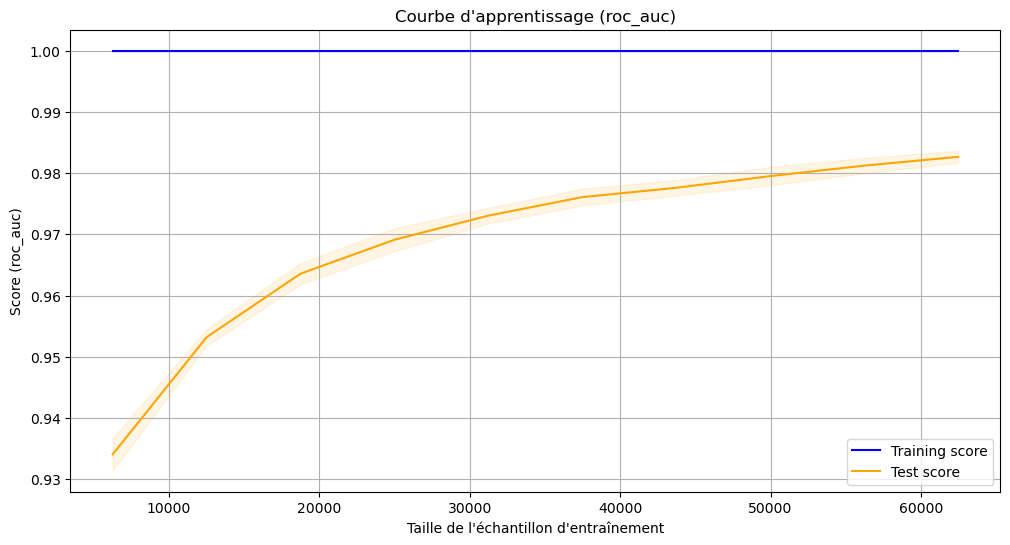


=== Risk Estimation PU Learning Results ===
Risque estimé sur le test : 0.5777
ROC-AUC Score : 0.98439422631357
F1-Score : 0.8275661529514394
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     15549
           1       0.98      0.72      0.83      3976

    accuracy                           0.94     19525
   macro avg       0.96      0.86      0.90     19525
weighted avg       0.94      0.94      0.94     19525



In [27]:
# Approche 1 : Two-Step Learning
clf_two_step = two_step_learning(X_train, y_train, X_test, y_test)

# Approche 2 : Weighted Random Forest
clf_weighted_rf = weighted_random_forest(X_train, y_train, X_test, y_test)

# Approche 3 : Risk Estimation PU Learning
clf_risk_estimation = risk_estimation_pu_learning(X_train, y_train, X_test, y_test)

**Interprétation des Résultats**

**Résultats pour les Trois Approches**
Les résultats des trois méthodes de PU Learning sont résumés ci-dessous, mettant en évidence leurs performances en termes de métriques clés comme le **ROC-AUC**, le **F1-Score**, et les mesures de précision et rappel pour les classes positives et négatives.

1. **Two-Step Learning**
- **ROC-AUC Score** : 0.976
- **F1-Score** : 0.817
- **Interprétation** :
  - Le score ROC-AUC élevé (\(~98\%\)) montre que le modèle est capable de discriminer efficacement entre les classes positives et négatives.
  - Cependant, le F1-Score (\(81.7\%\)) indique une légère baisse dans l'équilibre entre la précision et le rappel pour la classe positive.
  - **Précision et rappel** pour la classe positive (\(y = 1\)) :
    - **Précision** : \(98\%\) — Une grande majorité des prédictions positives sont correctes.
    - **Rappel** : \(70\%\) — Le modèle manque encore \(30\%\) des vrais positifs.
  - Cette méthode est efficace mais souffre légèrement d'un faible rappel pour la classe positive.

---

2. **Weighted Random Forest**
- **ROC-AUC Score** : 0.986
- **F1-Score** : 0.828
- **Interprétation** :
  - Cette méthode obtient la meilleure performance en termes de ROC-AUC (\(98.6\%\)), montrant une excellente séparation des classes.
  - Le **F1-Score** (\(82.8\%\)) est légèrement supérieur à celui de la méthode Two-Step Learning.
  - **Précision et rappel** pour la classe positive :
    - **Précision** : \(98\%\) — Très peu de faux positifs.
    - **Rappel** : \(72\%\) — Une amélioration par rapport à Two-Step Learning.
  - **Conclusion** : Le Weighted Random Forest offre un meilleur équilibre entre précision et rappel, ce qui en fait une méthode robuste pour ce cas de PU Learning.

---

3. **Risk Estimation PU Learning**
- **Prior estimé (\(\pi_P\))** : 0.8699
- **Risque estimé sur le test** : 0.5777
- **ROC-AUC Score** : 0.984
- **F1-Score** : 0.828
- **Interprétation** :
  - Cette approche atteint un **ROC-AUC** similaire au Weighted Random Forest (\(98.4\%\)) et un **F1-Score** (\(82.8\%\)) équivalent.
  - **Précision et rappel** pour la classe positive :
    - **Précision** : \(98\%\) — Presque toutes les prédictions positives sont correctes.
    - **Rappel** : \(72\%\) — Comparable au Weighted Random Forest.
  - Le risque estimé sur le test (\(0.5777\)) suggère une performance globale satisfaisante, confirmée par les scores élevés.

---

**Analyse Comparée des Méthodes**
- **ROC-AUC** : Les trois approches offrent des performances comparables, avec des scores supérieurs à \(97.5\%\), ce qui reflète une forte capacité de discrimination.
- **F1-Score** : Le Weighted Random Forest et le Risk Estimation PU Learning obtiennent les meilleurs scores (\(82.8\%\)), indiquant un bon équilibre entre précision et rappel.

In [28]:
# Approche 3 Améliorée: Risk Estimation PU Learning
clf_risk_estimation1 = risk_estimation_pu_learning1(X_train, y_train, X_test, y_test)

/home/nsnidi/miniconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/nsnidi/miniconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/nsnidi/miniconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Prior estimé (pi_P) : 0.9433

=== Risk Estimation PU Learning Results ===
Risque estimé sur le test : 0.6365
ROC-AUC Score : 0.984957909719556
F1-Score : 0.8435081685296647
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     15549
           1       0.98      0.74      0.84      3976

    accuracy                           0.94     19525
   macro avg       0.96      0.87      0.90     19525
weighted avg       0.95      0.94      0.94     19525



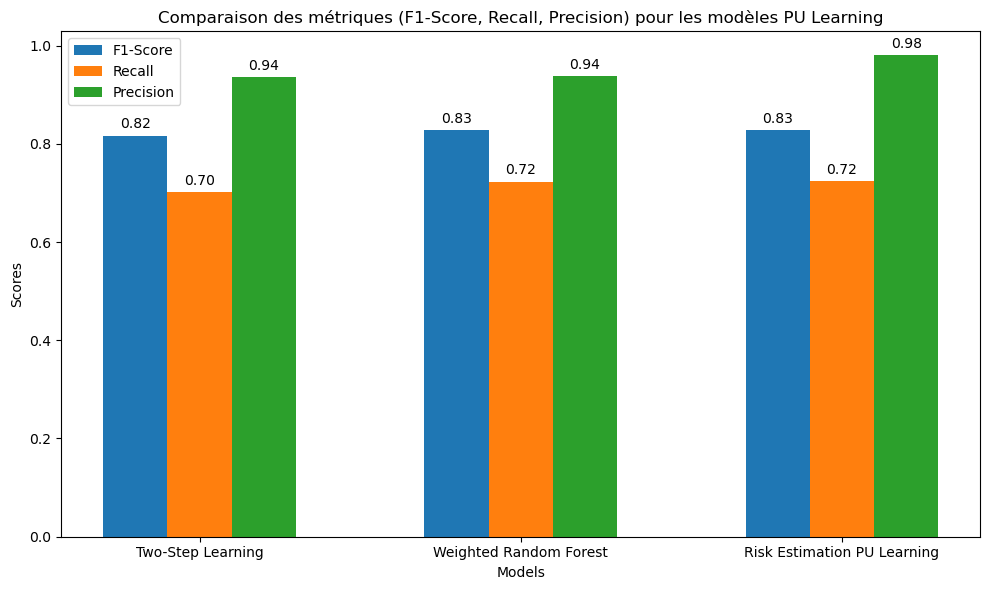

In [46]:
# Nom des modèles
models = ['Two-Step Learning', 'Weighted Random Forest', 'Risk Estimation PU Learning']

# Données des métriques pour chaque modèle
f1_scores = [0.8166, 0.8276, 0.8276]
recalls = [0.701, 0.723, 0.724]
precisions = [0.936, 0.938, 0.980]

# Position des barres
x = np.arange(len(models))

# Largeur des barres
width = 0.2

# Création du graphique
fig, ax = plt.subplots(figsize=(10, 6))

# Barres pour chaque métrique
rects1 = ax.bar(x - width, f1_scores, width, label='F1-Score')
rects2 = ax.bar(x, recalls, width, label='Recall')
rects3 = ax.bar(x + width, precisions, width, label='Precision')

# Ajout de labels et titres
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Comparaison des métriques (F1-Score, Recall, Precision) pour les modèles PU Learning')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Affichage des valeurs sur chaque barre
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # décalage du texte
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)
add_labels(rects3)

# Affichage du graphique
plt.tight_layout()
plt.show()

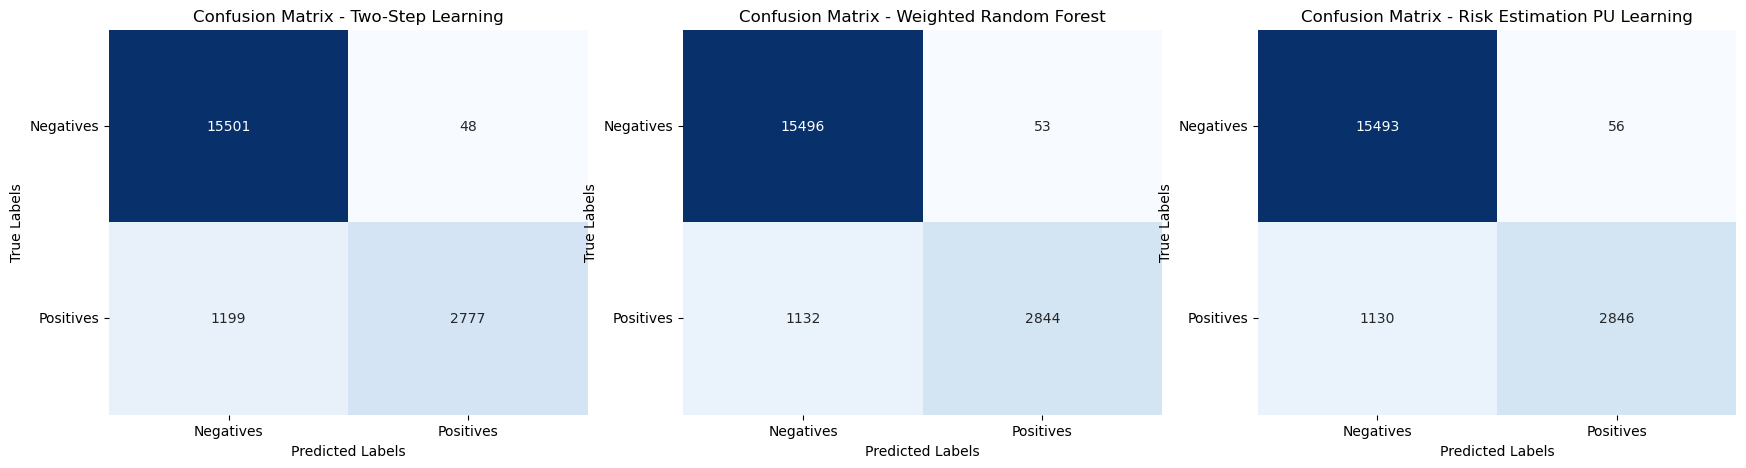

In [45]:
# Les matrices de confusion pour chaque modèle
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Matrices de confusion
confusion_matrices = {
    "Two-Step Learning": confusion_matrix(y_test, clf_two_step.predict(X_test)),
    "Weighted Random Forest": confusion_matrix(y_test, clf_weighted_rf.predict(X_test)),
    "Risk Estimation PU Learning": confusion_matrix(y_test, clf_risk_estimation.predict(X_test))
}

# Afficher les matrices de confusion
fig, axes = plt.subplots(1, 3, figsize=(21, 5))
labels = ["Negatives", "Positives"]
for i, (method, matrix) in enumerate(confusion_matrices.items()):
    ax = axes[i]
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
    ax.set_title(f"Confusion Matrix - {method}")
    ax.set_xlabel("Predicted Labels")
    ax.set_ylabel("True Labels")
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels, rotation=0)


**Interprétation des Résultats**

**Matrices de Confusion**

Les matrices de confusion fournissent une vue détaillée des performances des trois approches utilisées pour le PU Learning : **Two-Step Learning**, **Weighted Random Forest**, et **Risk Estimation PU Learning**.

1. **Two-Step Learning**
- **Vrais négatifs (TN)** : 15,501 exemples correctement classés comme négatifs.
- **Faux positifs (FP)** : 48 exemples négatifs incorrectement classés comme positifs.
- **Faux négatifs (FN)** : 1,199 exemples positifs incorrectement classés comme négatifs.
- **Vrais positifs (TP)** : 2,777 exemples positifs correctement identifiés.

Malgré des performances solides pour détecter les négatifs, le nombre relativement élevé de faux négatifs (FN) limite l'efficacité pour identifier les positifs.

2. **Weighted Random Forest**
- **Vrais négatifs (TN)** : 15,496 exemples négatifs correctement identifiés.
- **Faux positifs (FP)** : 53 erreurs dans les négatifs classés comme positifs.
- **Faux négatifs (FN)** : 1,132 exemples positifs non détectés.
- **Vrais positifs (TP)** : 2,844 exemples positifs correctement classifiés.

Cette approche améliore la détection des positifs par rapport à **Two-Step Learning**, avec une réduction notable du nombre de faux négatifs, tout en conservant de solides performances pour les négatifs.

3. **Risk Estimation PU Learning**
- **Vrais négatifs (TN)** : 15,493 exemples négatifs correctement identifiés.
- **Faux positifs (FP)** : 56 erreurs dans les négatifs classés comme positifs.
- **Faux négatifs (FN)** : 1,130 exemples positifs non détectés.
- **Vrais positifs (TP)** : 2,846 exemples positifs correctement identifiés.

Les performances sont similaires à celles de **Weighted Random Forest**, avec un compromis entre la classification des négatifs (légèrement plus de FP) et une meilleure détection des positifs.

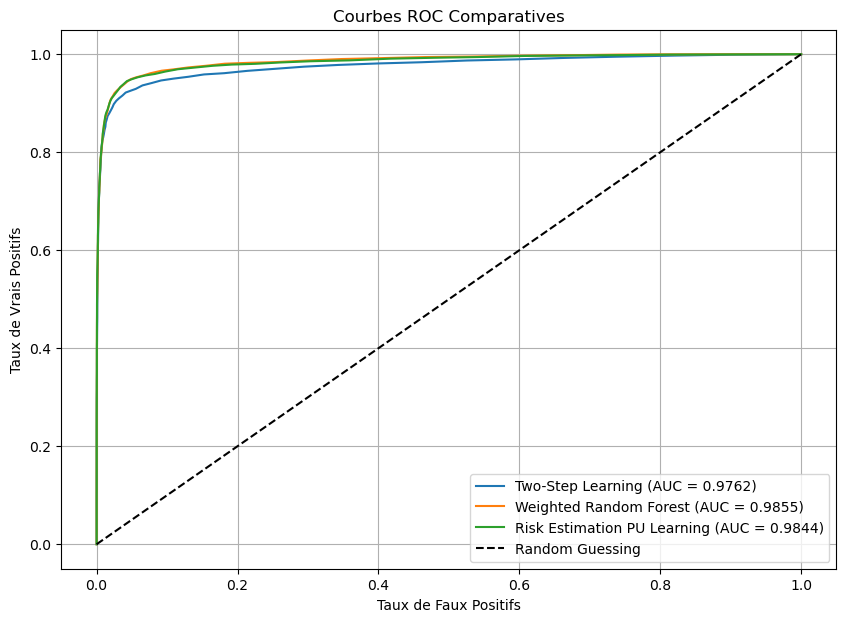

In [31]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curves(models, X_test, y_test):
    plt.figure(figsize=(10, 7))
    
    for name, model in models.items():
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.4f})")
    
    plt.plot([0, 1], [0, 1], "k--", label="Random Guessing")
    plt.title("Courbes ROC Comparatives")
    plt.xlabel("Taux de Faux Positifs")
    plt.ylabel("Taux de Vrais Positifs")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

# Modèles à comparer
models = {
    "Two-Step Learning": clf_two_step,  # Modèle 2-step entraîné
    "Weighted Random Forest": clf_weighted_rf,  # Modèle Weighted Random Forest entraîné
    "Risk Estimation PU Learning": clf_risk_estimation  # Modèle PU Learning
}

plot_roc_curves(models, X_test, y_test)


**Courbes ROC**

La courbe ROC illustre les performances des modèles en termes de compromis entre le **taux de vrais positifs** et le **taux de faux positifs**. Voici les observations pour chaque approche :

1. **Two-Step Learning**
- **AUC (Area Under the Curve)** : 0.9762  
Cette méthode offre des performances élevées, mais légèrement inférieures aux deux autres modèles en termes de séparation entre les classes positives et négatives.

2. **Weighted Random Forest**
- **AUC** : 0.9855  
Ce modèle surpasse **Two-Step Learning**, avec une courbe ROC plus proche du coin supérieur gauche, indiquant une meilleure capacité à distinguer entre les classes.

3. **Risk Estimation PU Learning**
- **AUC** : 0.9844  
Les performances sont comparables à celles de **Weighted Random Forest**, démontrant une excellente efficacité tout en intégrant une estimation du risque ajusté.

---

**Analyse Comparative**
- Les trois modèles présentent des courbes ROC très performantes, avec des AUC supérieurs à 0.97, ce qui indique une forte capacité de classification.
- **Weighted Random Forest** obtient le meilleur AUC, suivi de près par **Risk Estimation PU Learning**, tandis que **Two-Step Learning** reste compétitif mais légèrement en retrait.
- Sur les matrices de confusion, **Weighted Random Forest** et **Risk Estimation PU Learning** montrent une meilleure gestion des faux négatifs, rendant ces approches plus adaptées pour maximiser la détection des classes positives.

**Cross Validation**

Ce projet implémente la **Leave-Group-Out Cross-Validation (LGOCV)** pour évaluer plusieurs modèles de machine learning en utilisant les métriques **F1-Score** et **ROC-AUC**. La validation croisée permet de diviser les données en groupes et de s'assurer que les échantillons d'un même groupe ne sont pas présents à la fois dans l'entraînement et le test. Cela permet une évaluation plus robuste des modèles, en particulier dans le cadre d'ensembles de données avec des structures ou des dépendances particulières.

**Modèles Évalués**

Les modèles suivants ont été évalués dans ce cadre de validation croisée :

1. **Risk Estimation PU Learning**
Le modèle de **Risk Estimation PU Learning** repose sur un classifieur **Random Forest** pour estimer un prior (pi_P), représentant la proportion de données positives dans un ensemble non étiqueté. Ce modèle ajuste ses prédictions en fonction de ce prior, en cherchant à minimiser un risque combiné pour les classes positives et non étiquetées.

2. **Two-Step Learning**
Le modèle **Two-Step Learning** combine deux phases d'apprentissage distinctes. Dans un premier temps, il apprend à partir des données étiquetées, puis dans un second temps, il affine son modèle en utilisant des données non étiquetées. (Détails supplémentaires peuvent être ajoutés selon la méthode exacte utilisée).

3. **Weighted Random Forest**
Le modèle **Weighted Random Forest** utilise un classifieur **Random Forest** pondéré où l'importance des échantillons est ajustée en fonction de la distribution des classes. Ce modèle est conçu pour améliorer les performances sur des ensembles de données déséquilibrés.

**Processus de Validation Croisée : Leave-Group-Out Cross-Validation (LGOCV)**

Le processus de **Leave-Group-Out Cross-Validation (LGOCV)** divise les données en plusieurs groupes à l'aide de **GroupKFold**. Cette méthode garantit que les échantillons d'un même groupe ne sont jamais présents à la fois dans l'ensemble d'entraînement et l'ensemble de test, permettant ainsi une évaluation plus fiable.

**Étapes de la validation croisée :**
1. **Division des données en groupes** : Utilisation de **GroupKFold** pour diviser les données en plusieurs groupes.
2. **Entraînement et évaluation** : Pour chaque itération, un modèle est entraîné sur les données d'entraînement et évalué sur les données de test, avec des prédictions basées sur le F1-Score et le ROC-AUC.
3. **Calcul des métriques** : Le **F1-Score** (moyenne pondérée) et le **ROC-AUC** sont calculés à chaque itération et les résultats sont moyennés.

**Résultats**

À la fin de la validation croisée, les résultats de chaque modèle sont présentés sous forme de moyennes et d'écarts-types des métriques suivantes :

- **F1-Score** : Mesure de la performance du modèle prenant en compte la précision et le rappel, particulièrement utile pour les classes déséquilibrées.
- **ROC-AUC** : Mesure de la capacité du modèle à distinguer les classes positives des classes négatives.

Les résultats permettent de comparer les performances des différents modèles et de sélectionner le plus performant selon les critères choisis.

**Objectif**

L'objectif de ce projet est d'évaluer les différents modèles de manière rigoureuse en tenant compte des groupes spécifiques dans les données. Cette méthode permet d'obtenir des estimations plus fiables de la capacité des modèles à généraliser sur de nouvelles données.


In [58]:
from sklearn.model_selection import GroupKFold

# Fonction de validation croisée mise à jour
def cross_val_with_lgocv(X, y, group, model, n_splits=5):
    """
    Effectue la validation croisée Leave-Group-Out Cross-Validation (LGOCV)
    pour plusieurs modèles et évalue les performances.
    """
    group_kfold = GroupKFold(n_splits=n_splits)
    
    results = {
        'clf_risk': [],
        'f1_score': [],
        'roc_auc': []
    }

    # Validation croisée
    for train_idx, test_idx in group_kfold.split(X, y, groups=group):
        # Séparation des données en entraînement et test
        X_train_cv, X_test_cv = X.iloc[train_idx], X.iloc[test_idx]
        y_train_cv, y_test_cv = y.iloc[train_idx], y.iloc[test_idx]
        
        # Entraînement et évaluation du modèle Risk Estimation PU Learning
        output = model(X_train_cv, y_train_cv, X_test_cv, y_test_cv)
        
        # Vérification des valeurs retournées
        if isinstance(output, tuple):
            # Si le modèle retourne un tuple, alors extraire les valeurs nécessaires
            clf_risk, test_risk, _, y_pred, y_pred_proba = output
        else:
            # Si le modèle retourne autre chose, adapter ici en fonction des valeurs retournées
            clf_risk, test_risk, y_pred, y_pred_proba = output
        
        # Calcul des métriques
        f1 = f1_score(y_test_cv, y_pred)
        roc_auc = roc_auc_score(y_test_cv, y_pred_proba)

        # Sauvegarder les résultats
        results['clf_risk'].append(clf_risk)
        results['f1_score'].append(f1)
        results['roc_auc'].append(roc_auc)

    # Affichage des résultats moyens
    print(f"F1-Score moyen : {np.mean(results['f1_score']):.4f} ± {np.std(results['f1_score']):.4f}")
    print(f"ROC-AUC moyen : {np.mean(results['roc_auc']):.4f} ± {np.std(results['roc_auc']):.4f}")

    return results


In [59]:
results_risk_estimation = cross_val_with_lgocv(X_selected, y, group=X_selected.index, model=risk_estimation_pu_learning, n_splits=5)
results_weighted_rf = cross_val_with_lgocv(X_selected, y, group=X_selected.index, model=weighted_random_forest, n_splits=5)
results_two_step = cross_val_with_lgocv(X_selected, y, group=X_selected.index, model=two_step_learning, n_splits=5)

KeyboardInterrupt: 